In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Function to generate graphene lattice points
def graphene_lattice(a=1, size=10): 
    # lattice const, a: dist. bw adj. atoms
    # size: number of unit cells along each direction
    # Graphene lattice vectors
    A = np.array([np.sqrt(3)*a, 0])
    B = np.array([np.sqrt(3)*a/2, 3 * a / 2])   
    # Generate lattice points
    pts= []
    for i in range(size):
        for j in range(size):
            offset= np.array([i * A[0] + j * B[0], i * A[1] + j * B[1]])
            pts.append(offset)  
    return np.array(pts)

# Function to rotate the lattice by an angle
def rotate_lattice(pts, angle_deg):
    angle_rad = np.radians(angle_deg)
    rotation_mtrx = np.array([[np.cos(angle_rad), -np.sin(angle_rad)],
                                [np.sin(angle_rad), np.cos(angle_rad)]])
    rotated_pts = np.dot(pts, rotation_mtrx.T)  # Apply the rotation
    # multiplies each point (each row in points) by the rotation matrix, rotating all pts
    return rotated_pts

# Plotting the lattices
def plot_lattices(lattice1, lattice2=None):
    plt.figure(figsize=(8, 8))
    plt.scatter(lattice1[:, 0], lattice1[:, 1], color='blue', label='Layer 1', s=5, alpha=0.6)
    if lattice2 is not None:
        plt.scatter(lattice2[:, 0], lattice2[:, 1], color='red', label='Layer 2', s=5, alpha=0.6)
    plt.gca().set_aspect('equal', adjustable='box') # "Get Current Axis"
    plt.legend()
    plt.title('Graphene Lattice and Moiré Pattern')
    plt.show()

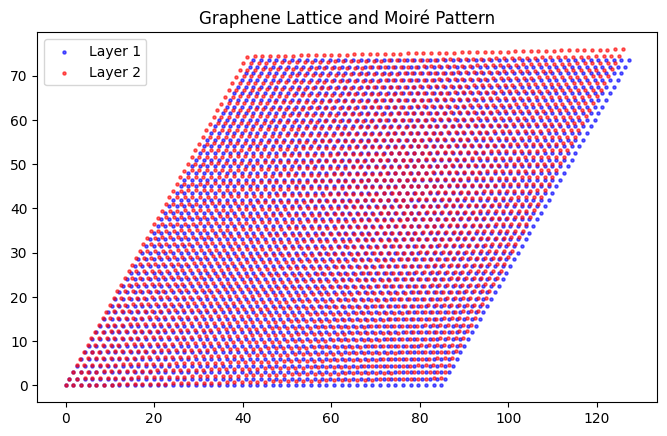

In [3]:
size = 50
lattice1 = graphene_lattice(size=size)
angle = 1.1  # degrees
lattice2 = rotate_lattice(lattice1, angle)
plot_lattices(lattice1, lattice2)

# Band structure tBLG

In [3]:
# Define constants
t = 2.7  # Nearest-neighbor hopping energy in eV
a = 1.42  # Carbon-carbon distance in Ångströms

# Create the 1D momentum grid (k-space)
k_vals = np.linspace(-np.pi, np.pi, 300)

In [4]:
# Tight-binding Hamiltonian function for twisted bilayer graphene (TBG)
def hamiltonian(k, theta):
    # Rotation matrix for the twist angle
    rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)], 
                                [np.sin(theta), np.cos(theta)]])   
    # Initialize the Hamiltonian matrix (2x2)
    H = np.zeros((2, 2), dtype=complex)  
    # Apply rotation to the k-point
    rotated_k = np.dot(rotation_matrix, np.array([k, 0]))  # 1D model, only kx matters
    # Define hopping terms (nearest-neighbor hopping in this example)
    H[0, 1] = t * np.exp(1j * rotated_k[0])  # Off-diagonal hopping term
    H[1, 0] = np.conj(H[0, 1])  # Hermitian conjugate for the other off-diagonal term
    return H
'''   
The matrix describes a two-component system
The off-diagonal entries describe how the two components are coupled
The coupling must be consistent in both directions
Complex conjugation ensures that consistency
'''

'   \nThe matrix describes a two-component system\nThe off-diagonal entries describe how the two components are coupled\nThe coupling must be consistent in both directions\nComplex conjugation ensures that consistency\n'

In [5]:
# Function to calculate and plot the band structure
def plot_band_structure(k_vals, theta):
    energies = [] 
    # Loop over each k value
    for k in k_vals:
        H_k = hamiltonian(k, theta)  # Compute Hamiltonian at this k-point
        eigenvalues, _ = np.linalg.eig(H_k)  # Calculate eigenvalues of H(k)
        energies.append(np.real(eigenvalues))  # Store the eigenvalues (energies)
    energies = np.array(energies)
    
    # Plot the band structure
    plt.figure(figsize=(8, 6))
    plt.plot(k_vals, energies[:, 0], label="Band 1")
    plt.plot(k_vals, energies[:, 1], label="Band 2")
    plt.title(f"Band Structure for Twist Angle: {np.degrees(theta)}°")
    plt.xlabel("Momentum (k)")
    plt.ylabel("Energy (eV)")
    plt.legend()
    plt.grid(True)
    plt.xlim(0, 6.28)
    plt.ylim(-6, 6)
    plt.show()
'''
energies.shape = (300, 2)
Each row → a k value
Each column → one eigenvalue (one “band”)
'''

'\nenergies.shape = (300, 2)\nEach row → a k value\nEach column → one eigenvalue (one “band”)\n'

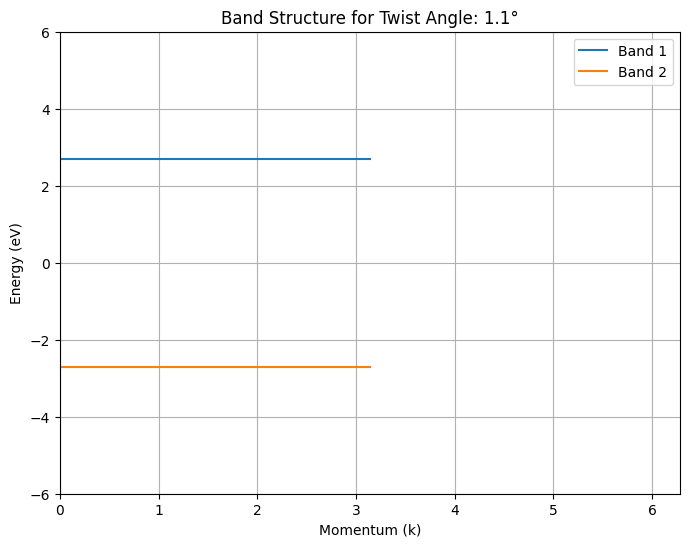

In [6]:
# Example simulation with twist angle (in radians)
theta = np.radians(1.1)  # Magic angle (in radians)
plot_band_structure(k_vals, theta)

# Velocity Extraction

In [ ]:
from numpy.linalg import eigvals

# Physical constants (scaled units)
vF =1.0      # set v_F = 1
w = 0.1       # interlayer coupling (tune this)
# Parameter alpha = w / (v_F * k_theta), here we set k_theta = 1 for simplicity

In [8]:
# Pauli matrices:
sigma_x = np.array([[0,1],[1,0]]) # 2x2
sigma_y = np.array([[0,-1j],[1j,0]])
# Dirac Hamiltonian:
def h_dirac(kx, ky):
    return vF * (kx * sigma_x + ky * sigma_y)  # 2x2

def bilayer_hamiltonian(kx, ky, alpha):
    T = alpha * np.eye(2)
    H = np.block([                  # 4x4
        [ h_dirac(kx, ky), T ],
        [ T, -h_dirac(kx, ky) ]
    ])
    return H

def velocity(alpha, dk=1e-4):
    # numerical derivative of lowest positive band
    E_dk = np.sort(eigvals(bilayer_hamiltonian(dk,0,alpha)).real) # -E2, -E1, E1, E2
    E_0= np.sort(eigvals(bilayer_hamiltonian(0,0,alpha)).real)
    return (E_dk[2] - E_0[2]) / dk  # v= dE/dk for the 3rd band (lowest positive)

In [10]:
alphas = np.linspace(0.1,1.2,400)
vels = np.array([velocity(a) for a in alphas])  

# magic angle condition
magic_alpha = alphas[np.argmin(np.abs(vels))]
print("Magic alpha ~", magic_alpha)
def effective_scalings(n):
    m = np.arange(1, n+1)
    lambdas = 2 * np.cos(m * np.pi / (n+1))
    return np.sort(np.abs(lambdas[lambdas != 0]))

print("n=3:", effective_scalings(3))
print("n=4:", effective_scalings(4))

Magic alpha ~ 1.2
n=3: [1.22464680e-16 1.41421356e+00 1.41421356e+00]
n=4: [0.61803399 0.61803399 1.61803399 1.61803399]
